In [54]:
from pathlib import Path

try:
    from google.colab import drive
    drive.mount("/content/drive")
    DATA_ROOT = Path("/content/drive/MyDrive/research/vision_transformer")
    CHECKPOINT_DIR = DATA_ROOT/"vit_cifar_checkpoints"
    EXPERIMENT_DIR = DATA_ROOT/"experiments"
except:
    DATA_ROOT = Path.home()/"Desktop/research"
    CHECKPOINT_DIR = Path.home()/"Desktop/projects/deep_learning_essentials/vision_transformer/vit_cifar_checkpoints"
    EXPERIMENT_DIR = Path.home()/"Desktop/projects/deep_learning_essentials/vision_transformer/experiments"

if not DATA_ROOT.exists():
    DATA_ROOT.parent.mkdir(parents=True, exist_ok=True)
    print("Created Data dir")
else:
    print("DATA_ROOT exists at : ", DATA_ROOT)
    
if not CHECKPOINT_DIR.exists():
    CHECKPOINT_DIR.parent.mkdir(parents=True, exist_ok=True)
    # CHECKPOINT_DIR.mkdir()/
    print("created CKPT dir")
else:
    print("ckpt exists at : ", CHECKPOINT_DIR)


DATA_ROOT exists at :  /home/avishkar/Desktop/research
ckpt exists at :  /home/avishkar/Desktop/projects/deep_learning_essentials/vision_transformer/vit_cifar_checkpoints


In [55]:
"""DATASET"""
import torch
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader


torch.manual_seed(42)

DATASET = "cifar10"
NUM_WORKERS = 2
BATCH_SIZE = 32 


train_dataset = datasets.CIFAR10(DATA_ROOT, train=True, download=True, transform= transforms.ToTensor())
test_dataset = datasets.CIFAR10(DATA_ROOT, train=False, download=True, transform= transforms.ToTensor())
print(f"trainset : {len(train_dataset)}, testset : {len(test_dataset)}")
classes = train_dataset.classes

# trainset = torch.utils.data.Subset(train_dataset, list(range(5000)))
# testset = torch.utils.data.Subset(test_dataset, list(range(1000)))

# prepare
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



Files already downloaded and verified
Files already downloaded and verified
trainset : 50000, testset : 10000


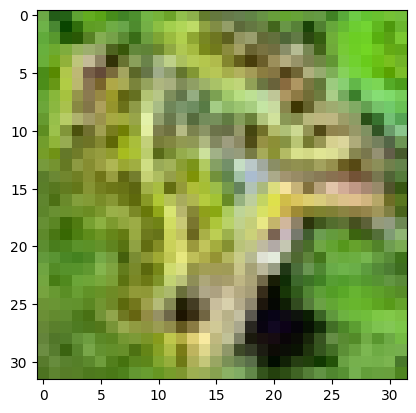

In [56]:
"""VISUALIZE DATA"""
import matplotlib.pyplot as plt

for i, (imgs, labels) in enumerate(train_loader):
    img = imgs[0]
    plt.imshow(img.T.cpu().numpy())
    plt.show()
    break
    


In [57]:
"""MODEL"""
"""based on official PyTorch source code based on original paper : https://pytorch.org/vision/main/models/vision_transformer.html"""

import torch
import torch.nn as nn
from collections import OrderedDict
import math

config = {
    "img_size":32,
	"patch_size":6,
	"num_channels":3,
	"num_layers":7,
	"num_heads":8,
	"embed_dim":768,
	"mlp_hidden_dim":4*768,
	"dropout":0.0,
	"num_classes":10,
    "lr":0.01,
    "device":"cuda" if torch.cuda.is_available() else "cpu",
    "num_epochs":100,
    "exp_name":"vit_cifar10_mark2_100_epochs",
    "save_model_every":0
}

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config["embed_dim"]
        self.hidden_dim = config["mlp_hidden_dim"]
        self.fc1 = nn.Linear(self.embed_dim, self.hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(self.hidden_dim, self.embed_dim)
        self.dropout=nn.Dropout(config["dropout"])

    def forward(self,x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_heads = config["num_heads"]
        self.embed_dim = config["embed_dim"]
            
        # Attention block
        self.layer_norm1 = nn.LayerNorm(self.embed_dim)
        self.self_attention = nn.MultiheadAttention(self.embed_dim, self.num_heads, dropout=config["dropout"], batch_first=True)
        self.dropout = nn.Dropout(config["dropout"])

        # MLP block
        self.layer_norm2 = nn.LayerNorm(self.embed_dim)
        self.mlp = MLP(config)

    def forward(self, inp: torch.Tensor):
        x = self.layer_norm1(inp) # inp as in  input
        x, _ = self.self_attention(x,x,x,need_weights=False)
        x = self.dropout(x)
        x = x + inp

        y = self.layer_norm2(x)
        y = self.mlp(y)

        return x+y



class Encoder(nn.Module):
    def __init__(self, seq_length ,config):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, config["embed_dim"]).normal_(std=0.02))  # from BERT
        self.dropout = nn.Dropout(config["dropout"])
        self.embed_dim =  config["embed_dim"]
        self.layers = nn.ModuleList([
			EncoderBlock(config) for _ in range(config["num_layers"])]
			)
        self.layer_norm = nn.LayerNorm(self.embed_dim)
    
    def forward(self, x):
        x = x + self.pos_embedding
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x)
        x = self.layer_norm(x)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.conv_proj = nn.Conv2d(
			config["num_channels"], 
		    config["embed_dim"],
			kernel_size=config["patch_size"],
			stride=config["patch_size"])
        self.patch_size = config["patch_size"]
        self.img_size = config["img_size"]
        self.embed_dim = config["embed_dim"]
        seq_length = (config["img_size"] // config["patch_size"]) ** 2
        self.class_token = nn.Parameter(torch.zeros(1, 1, config["embed_dim"]))
        seq_length += 1

        self.encoder = Encoder(seq_length, config)
        self.seq_length = seq_length

        heads_layers: OrderedDict[str, nn.Module] = OrderedDict()
        
        heads_layers["pre_logits"] = nn.Linear(config["embed_dim"], config["mlp_hidden_dim"])
        heads_layers["act"] = nn.Tanh()
        heads_layers["head"] = nn.Linear(config["mlp_hidden_dim"] ,config["num_classes"])

        self.heads = nn.Sequential(heads_layers)


        # Initializing weights

        if isinstance(self.conv_proj, nn.Conv2d):
            # Init the patchify stem
            fan_in = self.conv_proj.in_channels * self.conv_proj.kernel_size[0] * self.conv_proj.kernel_size[1]
            nn.init.trunc_normal_(self.conv_proj.weight, std=math.sqrt(1 / fan_in))
            if self.conv_proj.bias is not None:
                nn.init.zeros_(self.conv_proj.bias)
        elif self.conv_proj.conv_last is not None and isinstance(self.conv_proj.conv_last, nn.Conv2d):
            # Init the last 1x1 conv of the conv stem
            nn.init.normal_(
                self.conv_proj.conv_last.weight, mean=0.0, std=math.sqrt(2.0 / self.conv_proj.conv_last.out_channels)
            )
            if self.conv_proj.conv_last.bias is not None:
                nn.init.zeros_(self.conv_proj.conv_last.bias)

        if hasattr(self.heads, "pre_logits") and isinstance(self.heads.pre_logits, nn.Linear):
            fan_in = self.heads.pre_logits.in_features
            nn.init.trunc_normal_(self.heads.pre_logits.weight, std=math.sqrt(1 / fan_in))
            nn.init.zeros_(self.heads.pre_logits.bias)

        if isinstance(self.heads.head, nn.Linear):
            nn.init.zeros_(self.heads.head.weight)
            nn.init.zeros_(self.heads.head.bias)


    def forward(self,x ):
        n, c, h, w = x.shape
        p = self.patch_size
        torch._assert(h == self.img_size, f"Wrong image height! Expected {self.img_size} but got {h}!")
        torch._assert(w == self.img_size, f"Wrong image width! Expected {self.img_size} but got {w}!")
        n_h = h // p
        n_w = w // p

        # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
        x = self.conv_proj(x)
        # (n, hidden_dim, n_h, n_w) -> (n, hidden_dim, (n_h * n_w))
        x = x.reshape(n, self.embed_dim, n_h * n_w)

        # (n, hidden_dim, (n_h * n_w)) -> (n, (n_h * n_w), hidden_dim)
        # The self attention layer expects inputs in the format (N, S, E)
        # where S is the source sequence length, N is the batch size, E is the
        # embedding dimension
        x = x.permute(0, 2, 1)

        n = x.shape[0]

        # Expand the class token to the full batch
        batch_class_token = self.class_token.expand(n, -1, -1)
        x = torch.cat([batch_class_token, x], dim=1)

        x = self.encoder(x)

        # Classifier "token" as used by standard language architectures
        x = x[:, 0]

        x = self.heads(x)

        return x




In [58]:
"""UTILS"""
import json
from pathlib import Path

def save_checkpoint(state_dict, epoch, path):
    p = Path(path)
    if not p.exists():
        print("Creating folder")
        p.mkdir(parents=True, exist_ok=True)

    model_details = {
        "epoch":epoch,
        "state_dict": state_dict,
    }
    torch.save(model_details, f"{p}/vit_cifar10_{epoch}.pth")
    print(f"model saved at path : {p}/vit_cifar10_{epoch}.pth")


def load_pretrained(model, path, epoch):
    model.load_state_dict(torch.load(f"{path}/vit_cifar10_{epoch}.pth")["state_dict"])
    return model

def save_experiment(model, epoch, config, train_losses, test_losses, accuracies, path):
    exp_data = {
        "train_losses":train_losses,
        "test_losses":test_losses,
        "accuracies":accuracies,
        "epoch":epoch,
    }
    exp_name = config["exp_name"]
    config_file = path/f"{exp_name}"/"config.json"
    metrics_file = path/f"{exp_name}"/"metrics.json"
    files = [config_file , metrics_file]
    for file in files:
        if file.exists():
            print(f"{file} exists")
        else:
            file.parent.mkdir(parents=True, exist_ok=True)
            file.touch()
            print(f"{file} created")

    with open(config_file, "w") as f:
        json.dump(config, f, sort_keys=True, indent=4)
    with open(metrics_file, "w") as f:
        json.dump(exp_data, f, sort_keys=True, indent=4)

    save_checkpoint(model.state_dict(), epoch, path/f"{exp_name}")

def load_experiment(model ,exp_name, path):
    with open(path/f"{exp_name}"/"metrics.json", 'r') as file:
      data = json.load(file)
    train_losses=data["train_losses"]
    test_losses=data["test_losses"]
    accuracies=data["accuracies"]
    epoch=data["epoch"]

    model = load_pretrained(model, path/exp_name, epoch)

    return model, train_losses, test_losses, accuracies, epoch
    
    

In [59]:
import torch.optim as optim
import torch

class Trainer:
    def __init__(self, model, optimizer, criterion, device, path=CHECKPOINT_DIR):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.path=path
        self.exp_dir = EXPERIMENT_DIR

    def train(self, train_loader, test_loader, num_epochs, save_model_every_n_epochs=0):
        train_losses = []
        test_losses = []
        accuracies = [] 

        for i in range(num_epochs):
            train_loss = self.train_epoch(train_loader)
            accuracy, test_loss = self.evaluate(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            accuracies.append(accuracy)
            print(f"Epoch: {i+1}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
            if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0 and i+1 != num_epochs:
                print('\tSave checkpoint at epoch', i+1)
                save_checkpoint(self.model.state_dict(), i+1, train_losses, test_losses, accuracies, self.path)

        save_experiment(self.model, num_epochs, config, train_losses, test_losses, accuracies, self.exp_dir)

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        for i, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            predictions = self.model(imgs)
            loss = self.criterion(predictions, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()* len(imgs)

        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def evaluate(self, test_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        with torch.no_grad():
            for i, (imgs, labels) in enumerate(test_loader):
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                predictions = self.model(imgs)
                
                loss = self.criterion(predictions, labels)
                total_loss += loss.item() * len(imgs)

                 # Calculate the accuracy
                predictions = torch.argmax(predictions, dim=1)
                correct += torch.sum(predictions == labels).item()

        accuracy = correct / len(test_loader.dataset)
        avg_loss = total_loss / len(test_loader.dataset)
        return accuracy, avg_loss
            

def main():
    save_model_every_n_epochs = config["save_model_every"]
    model = VisionTransformer(config)
    optimizer = optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=1e-2)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, criterion, device=config["device"])
    trainer.train(train_loader, test_loader, config["num_epochs"], save_model_every_n_epochs=save_model_every_n_epochs)

In [60]:
"""TRAINING"""
if __name__ == "__main__":
    main()

KeyboardInterrupt: 

In [ ]:
"""VIS Loss, ACC"""

"""
def load_experiment(model ,exp_name, path):
    data = json.load(path/f"exp_name"/"metrics.json")
    train_losses=data["train_losses"]
    test_losses=data["test_losses"]
    accuracies=data["accuracies"]
    epoch=data["epoch"]

    model = load_pretrained(model, path, epoch)

    return model, train_losses, test_losses, accuracies, epoch
    """


import matplotlib.pyplot as plt

model = ViT(config)
_, train_losses, test_losses, accuracies,_ = load_experiment(model, config["exp_name"], EXPERIMENT_DIR)
# Create two subplots of train/test losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label="Train loss")
ax1.plot(test_losses, label="Test loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(accuracies)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.savefig("metrics.png")
plt.show()